# Age Detection of Indian Actors - AV Practice Problem

In [1]:
from theano.sandbox import cuda
cuda.use('gpu2')

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.sandbox.cuda): Ignoring call to use(2), GPU number 0 is already in use.


In [2]:
%matplotlib inline

In [3]:
# Importing relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.misc import *

In [4]:
import os, sys
from PIL import Image

In [5]:
DATA_HOME_DIR = os.getcwd()

In [6]:
%pwd

u'/home/ubuntu/AgeDetection_AV'

## Reading the class labels file

In [7]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [8]:
train.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [9]:
train.groupby(by = "Class").count()

,ID
Class,
MIDDLE,10804
OLD,2396
YOUNG,6706


## Data segregation and preparation

1. Create validation set out of the train set

2. Since there are 3 classes, each folder (Train/Validation) will have three sub-folders (Young/Middle/Old)

3. These 3 sub-folders will contain the relevant images based on the image-label mapping file (train.csv)



These steps have already been taken care of. We move on to data exploration stage.




In [39]:
# Moving all test images into one 'unknown' class folder

%cd $DATA_HOME_DIR/Test
%mkdir unknown
%mv *.jpg unknown/

/home/ubuntu/AgeDetection_AV/Test


## Data Exploration

In [13]:
path = DATA_HOME_DIR + '/Train/middle/'

In [14]:
from glob import glob
%cd $path
g = glob('*.jpg')

/home/ubuntu/AgeDetection_AV/Train/middle


In [19]:
## Displaying a random image from the chosen path (Train/Validation set)
i = np.random.choice(np.arange(len(g)))
im = Image.open(path+g[i])

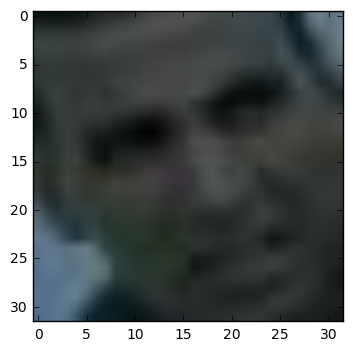

In [20]:
plt.imshow(im)

In [21]:
im.size

(32, 32)

### Preprocessing - Resizing all images

In [22]:
# Creating a custom resize function
def resize(path, size = 32):
    for item in os.listdir(path):
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((size,size), Image.ANTIALIAS)
            imResize.save(f + '.jpg', 'JPEG', quality=100)

In [85]:
## Resizing images in each of the Train and Validation set folders
path = DATA_HOME_DIR + '/Train/old/'
resize(path)

path = DATA_HOME_DIR + '/Train/middle/'
resize(path)

path = DATA_HOME_DIR + '/Train/young/'
resize(path)

path = DATA_HOME_DIR + '/Validation/old/'
resize(path)

path = DATA_HOME_DIR + '/Validation/middle/'
resize(path)

path = DATA_HOME_DIR + '/Validation/young/'
resize(path)

path = DATA_HOME_DIR + '/Test/'
resize(path)

### More pre-processing

a) Further pre-processing might include mean normalization/ standardization. This can be avoided by adding BatchNorm at the 1st layer (input layer) of the network.

b) Due to resizing, most of the images have become blurred. A sharpening filter can be used to restore some normalcy. However, adding a Conv. Layer will take of this as it will automatically learn this feature, if important and required.

In [23]:
%cd $DATA_HOME_DIR

/home/ubuntu/AgeDetection_AV


## Neural Network models - CNN and its variants

In [24]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import SGD
from keras.constraints import maxnorm

from keras import backend as K
K.set_image_dim_ordering('th')

from keras.preprocessing import image

Using Theano backend.


### Model 1 : Simple stacked CNN architecture with BatchNormalization

In [21]:
model = Sequential([
        BatchNormalization(input_shape = (3,32,32)),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(3, activation='softmax')
        ])
model.compile(optimizer = 'nadam' , loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 3, 32, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 30, 30)        896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 30, 30)        120       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 28, 28)        9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 28, 28)        112       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 14, 14)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 12, 12)        18496     
__________

In [26]:
gen = image.ImageDataGenerator()

### Model 2 : CNN with BatchNormalization and Data augmentation - with and w/o Dropout

In [76]:
model = Sequential([
        BatchNormalization(input_shape = (3,32,32)),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.2),
        Dense(384, activation='relu'),
        Dropout(0.6),
        Dense(3, activation='softmax')
        ])
model.compile(optimizer = 'adam' , loss='categorical_crossentropy', metrics=['accuracy'])

In [77]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, 3, 32, 32)         128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 30, 30)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 30, 30)        120       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 28, 28)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 28, 28)        112       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 14, 14)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 12, 12)        18496     
__________

In [29]:
## Generates augmented images to bring diversity to the training set and improve generalization
gen = image.ImageDataGenerator(rotation_range = 10, width_shift_range = 0.15, shear_range = 0.25,
                               height_shift_range = 0.15, zoom_range = 0.2, horizontal_flip = True)

In [30]:
trn_path = DATA_HOME_DIR + '/Train/'
val_path = DATA_HOME_DIR + '/Validation/'
test_path = DATA_HOME_DIR + '/Test/'

In [31]:
trn_batches = gen.flow_from_directory(trn_path, target_size = (32,32), class_mode = 'categorical', shuffle = True, batch_size = 64)
val_batches = gen.flow_from_directory(val_path, target_size = (32,32), class_mode = 'categorical', shuffle = False, batch_size = 128)

Found 16906 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


### Model 3 : Deep CNN network with pre-processing (RGB to Grayscale and/or PCA, ZCA whitening)

This part (model 3) is work-in-progress. RGB --> HSI --> Grayscale might work.

In [ ]:
#def rgb2gray(pixel):
#    return 0.3*pixel[0] + 0.59*pixel[1] + 0.11*pixel[2]

In [ ]:
#gray = np.zeros((image.shape[0], image.shape[1])) # init 2D numpy array
## get row number
#for rownum in range(len(image)):
#   for colnum in range(len(image[rownum])):
#      gray[rownum][colnum] = average(image[rownum][colnum]

## Model Training

In [35]:
## Building a custom function for learning rate decay/annealing
def lr_decay(start, stop, div_step_1, div_step_2 = 2) :
    k = 1
    while start >= stop:
        yield start
        if k==1 :
            start/= div_step_1
        else : start/= div_step_2
        k = k * -1

In [78]:
model.fit_generator(trn_batches, steps_per_epoch = (trn_batches.samples/trn_batches.batch_size), nb_epoch=1,
                   validation_data = val_batches, validation_steps = (val_batches.samples/val_batches.batch_size))

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  from ipykernel import kernelapp as app
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=3, validation_data=<keras.pre..., steps_per_epoch=264, validation_steps=23)`
  from ipykernel import kernelapp as app


Epoch 1/3
264/264 [==============================] - 119s - loss: 1.0539 - acc: 0.5390 - val_loss: 0.8883 - val_acc: 0.5700
Epoch 2/3
264/264 [==============================] - 119s - loss: 0.8621 - acc: 0.6093 - val_loss: 0.8305 - val_acc: 0.6146
Epoch 3/3
264/264 [==============================] - 119s - loss: 0.8004 - acc: 0.6479 - val_loss: 0.7721 - val_acc: 0.6386


In [79]:
model.optimizer.lr /= 2

In [80]:
model.fit_generator(trn_batches, steps_per_epoch = (trn_batches.samples/trn_batches.batch_size), nb_epoch=1,
                   validation_data = val_batches, validation_steps = (val_batches.samples/val_batches.batch_size))

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  from ipykernel import kernelapp as app
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=1, validation_data=<keras.pre..., steps_per_epoch=264, validation_steps=23)`
  from ipykernel import kernelapp as app


Epoch 1/1
264/264 [==============================] - 119s - loss: 0.7616 - acc: 0.6735 - val_loss: 0.7040 - val_acc: 0.6894


In [149]:
for i in lr_decay(0.005, 0.0002, 2, 5):
    model.optimizer.lr = i
    print "Learning rate = " + str(i)
    model.fit_generator(trn_batches, steps_per_epoch = (trn_batches.samples/trn_batches.batch_size), nb_epoch=3,
                   validation_data = val_batches, validation_steps = (val_batches.samples/val_batches.batch_size))

Learning rate = 0.001


/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=3, validation_data=<keras.pre..., steps_per_epoch=264, validation_steps=23)`


Epoch 1/3
264/264 [==============================] - 119s - loss: 1.0421 - acc: 0.5685 - val_loss: 0.8182 - val_acc: 0.6352
Epoch 2/3
264/264 [==============================] - 118s - loss: 0.8035 - acc: 0.6498 - val_loss: 0.7556 - val_acc: 0.6532
Epoch 3/3
264/264 [==============================] - 118s - loss: 0.7352 - acc: 0.6886 - val_loss: 0.6949 - val_acc: 0.6953
Learning rate = 0.0005
Epoch 1/3
264/264 [==============================] - 118s - loss: 0.6688 - acc: 0.7199 - val_loss: 0.8975 - val_acc: 0.6337
Epoch 2/3
264/264 [==============================] - 118s - loss: 0.6071 - acc: 0.7547 - val_loss: 0.9895 - val_acc: 0.6424
Epoch 3/3
264/264 [==============================] - 118s - loss: 0.4924 - acc: 0.8054 - val_loss: 1.5925 - val_acc: 0.5669


## Predicting results

In [81]:
test_batches = gen.flow_from_directory(test_path, target_size = (32,32), class_mode = None, shuffle = False, batch_size = 128)

Found 6636 images belonging to 1 classes.


In [82]:
preds = model.predict_generator(test_batches, (test_batches.samples/test_batches.batch_size)+1)

In [39]:
len(preds)

6636

In [83]:
preds[0:10,]

array([[  7.04968214e-01,   7.05065653e-02,   2.24525139e-01],
       [  9.61988389e-01,   4.70217288e-04,   3.75413932e-02],
       [  1.60703018e-01,   1.24944802e-02,   8.26802492e-01],
       [  1.95583686e-01,   3.94083671e-02,   7.65007913e-01],
       [  4.37830359e-01,   1.00856144e-02,   5.52084029e-01],
       [  3.17997843e-01,   4.93224524e-02,   6.32679760e-01],
       [  4.70964819e-01,   3.84464599e-02,   4.90588725e-01],
       [  7.85993338e-01,   4.08096462e-02,   1.73197016e-01],
       [  7.21277356e-01,   9.79174972e-02,   1.80805162e-01],
       [  3.16272765e-01,   5.23018800e-02,   6.31425261e-01]], dtype=float32)

In [84]:
class_labels = preds.argmax(axis = 1)

In [87]:
len(class_labels[class_labels == 0])

4212

In [56]:
len(class_labels)

6636

In [90]:
labels = []

for i in np.arange(0,len(class_labels)):
    if class_labels[i] == 0 : 
        labels.append('MIDDLE')
    elif class_labels[i] == 1 :
        labels.append('OLD')
    else : 
        labels.append('YOUNG')


In [46]:
filenames = test_batches.filenames

In [47]:
ids = np.char.array([f[8::] for f in filenames])

In [48]:
ids[0:10]

chararray(['16015.jpg', '7366.jpg', '6873.jpg', '23196.jpg', '4512.jpg',
           '23819.jpg', '3175.jpg', '2472.jpg', '1188.jpg', '22634.jpg'],
          dtype='|S9')

In [92]:
dict = {'Class': labels,'ID': ids}
result = pd.DataFrame(data = dict)

In [93]:
# Writing the results to a csv file
%cd $DATA_HOME_DIR
result.to_csv('subm.csv')

/home/ubuntu/AgeDetection_AV
